In [1]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/03-gravity/plot_1a_gravity_anomaly.html#sphx-glr-content-tutorials-03-gravity-plot-1a-gravity-anomaly-py

# !git clone https://github.com/simpeg/simpeg
# %cd simpeg
# !pip install -r requirements.txt
# !python setup.py install

import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc

from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import gravity

In [143]:
class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, xx, yy, zz, topografia=None):
        
        # Define a topografia do modelo.
        [x_topo, y_topo] = np.meshgrid(xx, yy)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(yy), len(xx)))

        self.xyz_topo = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]


        # Define a malha de tensores em células de tamanho regular
        dx, dy, dz = xx[1]-xx[0], yy[1]-yy[0], zz[1]-zz[0]

        nx = int((np.max(x)-np.min(x))/dx)
        ny = int((np.max(y)-np.min(y))/dy)
        nz = int((np.max(z)-np.min(z))/dz)

        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
    def plota_malha(self):
        self.mesh.plotGrid()
        #fig, ax1 = plt.subplots(figsize=(8,8))
        #self.mesh.plotGrid(ax=ax1)
        #ax.set_xbound(mesh.x0[0], mesh.x0[0] + np.sum(mesh.hx))
        #ax.set_ybound(mesh.x0[1], mesh.x0[1] + np.sum(mesh.hy))
        #ax.set_title("Tensor Mesh")

### O usuario configura o tamanho do modelo aqui.

In [144]:
eixo_x = [400.0, 10.0]      # [comprimento, delta]
eixo_y = [400.0, 10.0]      # [comprimento, delta]
eixo_z = [200.0, 10.0]      # [comprimento, delta]

meu_modelo = modelo(np.linspace(-1 * eixo_x[0]/2, eixo_x[0]/2, 1 + int(eixo_x[0]/eixo_x[1])), \
                    np.linspace(-1 * eixo_y[0]/2, eixo_y[0]/2, 1 + int(eixo_y[0]/eixo_y[1])), \
                    np.linspace(-1 * eixo_z[0]/2, eixo_z[0]/2, 1 + int(eixo_z[0]/eixo_z[1])), \
                    topografia='default')

In [146]:
def config_aquisicao(x_lims, nx, y_lims, ny):
    
    """
    Define os pontos do levantamento
    """
    
    coord_x = np.linspace(x_lims[0], x_lims[1], nx)
    coord_y = np.linspace(y_lims[0], y_lims[1], ny)
    x, y = np.meshgrid(coord_x, coord_y)

    x = mkvc(x.T)
    y = mkvc(y.T)

    # cria a função de interpolação para o espaço do modelo
    fun_interp = LinearNDInterpolator(np.c_[mod_space[:, 0], mod_space[:, 1]], mod_space[:, 2])

    # interpola as coordenadas das estações e coloca 5.0 m acima da superfície
    z = fun_interp(np.c_[x, y])

    receiver_locations = np.c_[x, y, z]

    # Define the component(s) of the field we want to simulate as strings within
    # a list. Here we simulate only the vertical component of gravity anomaly.
    components = ['gz']

    # Use the observation locations and components to define the receivers. To
    # simulate data, the receivers must be defined as a list.
    receiver_list = gravity.receivers.Point(receiver_locations, components=components)

    receiver_list = [receiver_list]

    # Defining the source field.
    source_field = gravity.sources.SourceField(receiver_list=receiver_list)

    # Defining the survey
    survey = gravity.survey.Survey(source_field)    # é um objeto

    return survey

10.0 10.0 10.0


AttributeError: 'Line2D' object has no property 'zs'

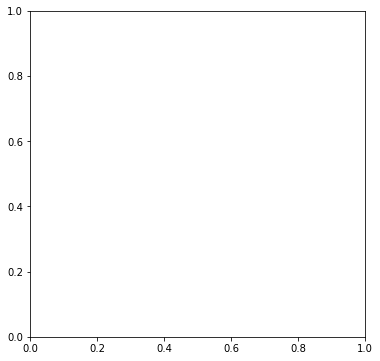

In [128]:

# eixo definido no modelo
x, y = np.linspace(-200, 200, 41), np.linspace(-200, 200, 41)
z = np.linspace(0, 200, 21)




# discretização
dx, dy, dz = x[1]-x[0], y[1]-y[0], z[1]-z[0]     # tamanho da célula - o usuário só mexe aqui

print(dx, dy, dz)

nx = int((np.max(x)-np.min(x))/dx)
ny = int((np.max(y)-np.min(y))/dy)
nz = int((np.max(z)-np.min(z))/dz)

hx = [(dx, nx)]
hy = [(dy, ny)]
hz = [(dz, nz)]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
TensorMesh([hx, hy, hz], 'CCN').plotGrid(ax=ax)
ax.set_xbound(mesh.x0[0], mesh.x0[0] + np.sum(mesh.hx))
ax.set_ybound(mesh.x0[1], mesh.x0[1] + np.sum(mesh.hy))
ax.set_title("Tensor Mesh")


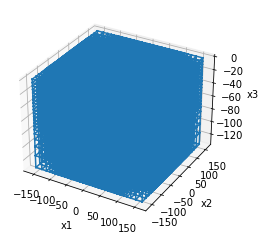

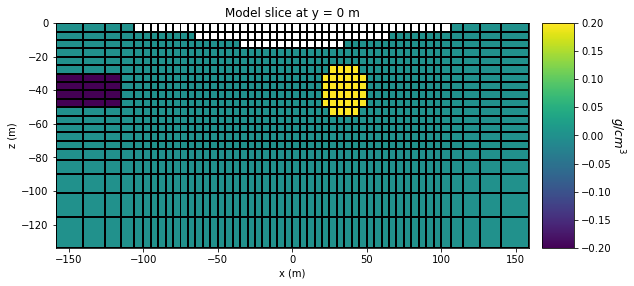

In [59]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2


# Defining a Tensor Mesh
# Here, we create the tensor mesh that will be used to predict gravity anomaly data.
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")


# Find the indices for the active mesh cells (e.g. cells below surface)
ind_active = surface2ind_topo(mesh, mod_space)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -150.0)      # xi
    & (mesh.gridCC[ind_active, 0] < -120.0)    # xf
    & (mesh.gridCC[ind_active, 1] > -15.0)    # yi
    & (mesh.gridCC[ind_active, 1] < 15.0)     # yf
    & (mesh.gridCC[ind_active, 2] > -50.0)    # zi
    & (mesh.gridCC[ind_active, 2] < -30.0)    # zf
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

In [7]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

NameError: name 'survey' is not defined